In [3]:
# Import modules
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Import network objects
from PolicyNetwork import PolicyNetwork
from ValueNetwork import ValueNetwork

In [20]:
print('cuda' if torch.cuda.is_available() else 'cpu')

cpu


In [23]:
# Train using gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_of_sensors = 50
input_size = 4*num_of_sensors+2

accel_policy = PolicyNetwork(input_size)
turn_policy = PolicyNetwork(input_size)
value_function = ValueNetwork(input_size)

# Network locations
acceleration_path = 'models/acceleration_network.pth'
turn_path = 'models/turn_network.pth'
value_path = 'models/value_network.pth'

# Load networks
accel_policy.load_state_dict(torch.load(acceleration_path))
turn_policy.load_state_dict(torch.load(turn_path))
value_function.load_state_dict(torch.load(value_path))


<All keys matched successfully>

In [34]:
# Load and read trajectory csv file
trajectories_file = 'data/trajectories.csv'
trajectories = pd.read_csv(trajectories_file)

# Store trajectory values into state, action, reward vectors
states = trajectories.iloc[:, 1:-3].values
actions = trajectories.iloc[:, -3:-1].values
rewards = trajectories.iloc[:, -1:].values

# Calculate reward-to-go
reward_to_go = np.array([[reward[0]] for reward in rewards])
for i in range(len(reward_to_go)-2,-1,-1): reward_to_go[i][0] += reward_to_go[i][0]

# Convert to tensor
states_tensor = torch.tensor(states).float()
actions_tensor = torch.tensor(states).float()
reward_to_go_tensor = torch.tensor(states).float()

#Store in dataset
dataset = TensorDataset(states_tensor, reward_to_go_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Train value function

C:\Users\mattd\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 202])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\mattd\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([7, 202])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


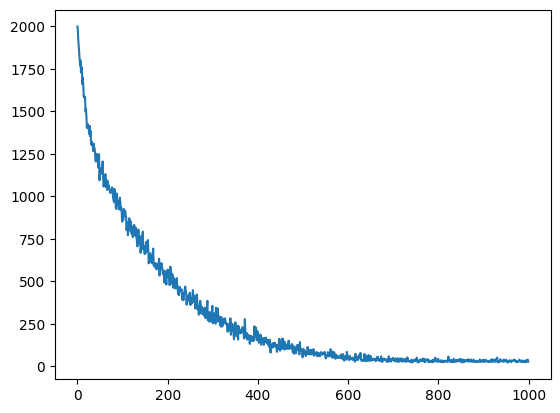

In [35]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(value_function.parameters(), lr=0.0001, weight_decay=0.0001)

losses = []
epochs = 1000
for epoch in range(epochs):
    for inputs_batch, outputs_batch in dataloader:
        # Move batches to GPU
        inputs_batch, outputs_batch = inputs_batch.to(device), outputs_batch.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = value_function(inputs_batch)

        # Compute the loss
        loss = loss_function(predictions, outputs_batch)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()

    losses.append(loss.item())
    
plt.plot(losses)
plt.show()

Train Policy Networks

In [38]:
policy_optimizer = optim.Adam(list(accel_policy.parameters())+list(turn_policy.parameters()),lr=0.0001)
value_optimizer = optim.Adam(value_function.parameters(),lr=0.0001)

epsilon = 0.2 # Clipping factor

for epoch in range(epoch):

    # Clone current policy and value networks
    accel_policy_old = accel_policy.clone()
    turn_policy_old = turn_policy.clone()
    value_function_old = value_function.clone()

    values = value_function(states)

    # Freeze clone networks
    for param in accel_policy_old.parameters(): param.requires_grad = False
    for param in turn_policy_old.parameters(): param.requires_grad = False
    for param in value_function_old.parameters(): param.requires_grad = False

    # Calculate advantages
    advantages = reward_to_go - value_function_old(states).numpy()

    # Get old policy distribution from policy networks
    accel_mean_old, accel_stdev_old = accel_policy_old(states)[:,0],accel_policy_old(states)[:,1]
    turn_mean_old, turn_stdev_old = turn_policy_old(states)[:,0],turn_policy_old(states)[:,1]
    # Get new policy distribution from policy networks
    accel_mean, accel_stdev = accel_policy(states)[:,0],accel_policy(states)[:,1]
    turn_mean, turn_stdev = turn_policy(states)[:,0],turn_policy(states)[:,1]

    # Get acceleration and turn from actions taken
    accelerations = actions[:,0]
    turns = actions[:,1]

    # Calulate probability given action using density function
    pi = (1 / (accel_stdev * torch.sqrt(torch.tensor(2 * torch.pi)))) * torch.exp(-0.5 * ((accelerations - accel_mean) / accel_stdev) ** 2) * (1 / (turn_stdev * torch.sqrt(torch.tensor(2 * torch.pi)))) * torch.exp(-0.5 * ((turns - turn_mean) / turn_stdev) ** 2)
    pi_old = (1 / (accel_stdev_old * torch.sqrt(torch.tensor(2 * torch.pi)))) * torch.exp(-0.5 * ((accelerations - accel_mean_old) / accel_stdev_old) ** 2) * (1 / (turn_stdev_old * torch.sqrt(torch.tensor(2 * torch.pi)))) * torch.exp(-0.5 * ((turns - turn_mean_old) / turn_stdev_old) ** 2)
    
    # Calculate probability ratios
    ratios = pi / pi_old

    # Compute PPO loss
    surr1 = ratios * advantages
    surr2 = torch.clamp(ratios, 1 - epsilon, 1 + epsilon) * advantages # Clipping
    ppo_loss = -min(surr1,surr2).mean()

    # Update policy net
    policy_optimizer.zero_grad()
    ppo_loss.backward()
    policy_optimizer.step()

    # Update value network
    value_loss = nn.MSELoss()(values,reward_to_go)
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()